# Machine Learning Models on the IDS 2017

In this notebook, decision tree and random forest based machine learning algorithms are applied to the ids2017 dataset. Several methods for resolving the class imbalance are tested. Decision tree algorithms were chosen for their effectiveness and the training time which were better than other machine learning models. RT and RF based algorithms performed better in the preliminary experiments

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, average_precision_score, make_scorer, precision_score, accuracy_score, confusion_matrix, recall_score, f1_score, roc_auc_score
from notebook_utils import upsample_dataset
%matplotlib inline
%load_ext autoreload
%autoreload 2
file_path = r"..\CIC-IDS-2017\CSVs\GeneratedLabelledFlows\TrafficLabelling\processed\ids2017_processed.csv"

def load_dataset(file_path):
    df = pd.read_csv(file_path)
    convert_dict = {'label': 'category'}
    df = df.astype(convert_dict)
    df.info()
    return df

attack_labels = {
    0: 'BENIGN',
    7: 'FTP-Patator',
    11: 'SSH-Patator',
    6: 'DoS slowloris',
    5: 'DoS Slowhttptest',
    4: 'DoS Hulk',
    3: 'DoS GoldenEye',
    8: 'Heartbleed',
    12: 'Web Attack - Brute Force',
    14: 'Web Attack - XSS',
    13: 'Web Attack - Sql Injection',
    9: 'Infiltration',
    1: 'Bot',
    10: 'PortScan',
    2: 'DDoS'
}

## 1. Preparing the Dataset

In [2]:
df = load_dataset(file_path)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2830743 entries, 0 to 2830742
Data columns (total 96 columns):
 #   Column                       Dtype   
---  ------                       -----   
 0   destination_port             int64   
 1   protocol                     int64   
 2   flow_duration                int64   
 3   total_fwd_packets            int64   
 4   total_backward_packets       int64   
 5   total_length_of_fwd_packets  float64 
 6   total_length_of_bwd_packets  float64 
 7   fwd_packet_length_max        float64 
 8   fwd_packet_length_min        float64 
 9   fwd_packet_length_mean       float64 
 10  fwd_packet_length_std        float64 
 11  bwd_packet_length_max        float64 
 12  bwd_packet_length_min        float64 
 13  bwd_packet_length_mean       float64 
 14  bwd_packet_length_std        float64 
 15  flow_bytes_s                 float64 
 16  flow_packets_s               float64 
 17  flow_iat_mean                float64 
 18  flow_iat_std          

#### Check for invalid values

In [3]:
# Select only numeric columns
numeric_columns = df.select_dtypes(include=[np.number]).columns

# Identify columns with NaN, infinity, or negative values
nan_columns = df[numeric_columns].columns[df[numeric_columns].isna().any()]
inf_columns = df[numeric_columns].columns[np.isinf(df[numeric_columns]).any()]
neg_columns = df[numeric_columns].columns[(df[numeric_columns] < 0).any()]

print("Columns with NaN values:", nan_columns.tolist())
print("Columns with infinite values:", inf_columns.tolist())
print("Columns with negative values:", neg_columns.tolist())

# Calculate the percentage of NaN, infinite, and negative values
nan_percentage = df[nan_columns].isna().mean() * 100
inf_percentage = df[inf_columns].map(lambda x: np.isinf(x)).mean() * 100
neg_percentage = df[neg_columns].map(lambda x: x < 0).mean() * 100

print("Percentage of NaN values in each column:\n", nan_percentage)
print("Percentage of infinite values in each column:\n", inf_percentage)
print("Percentage of negative values in each column:\n", neg_percentage)


Columns with NaN values: ['flow_bytes_s']
Columns with infinite values: ['flow_bytes_s', 'flow_packets_s']
Columns with negative values: ['flow_duration', 'flow_bytes_s', 'flow_packets_s', 'flow_iat_mean', 'flow_iat_max', 'flow_iat_min', 'fwd_iat_min', 'fwd_header_length', 'bwd_header_length', 'fwd_header_length_1', 'init_win_bytes_forward', 'init_win_bytes_backward', 'min_seg_size_forward']
Percentage of NaN values in each column:
 flow_bytes_s    0.047973
dtype: float64
Percentage of infinite values in each column:
 flow_bytes_s      0.053308
flow_packets_s    0.101281
dtype: float64
Percentage of negative values in each column:
 flow_duration               0.004063
flow_bytes_s                0.003003
flow_packets_s              0.004063
flow_iat_mean               0.004063
flow_iat_max                0.004063
flow_iat_min                0.102129
fwd_iat_min                 0.000601
fwd_header_length           0.001236
bwd_header_length           0.000777
fwd_header_length_1        

Given the low percentage of null values in only one column (0.4%), it is safe to drop the rows with NaN values. The same applies to th infinite values. For negative values, 2 columns have an extremely high percentage of negative values. We choose to drop the features "init_win_bytes_forward" and "init_win_bytes_backward" as the source of the negative sign is unknown. For the rest of the features, the percentages are low so the rows with negative values are dropped.

In [4]:
def replace_invalid(df):
    # Select only numeric columns
    numeric_columns = df.select_dtypes(include=[np.number]).columns
    
    # Identify columns with NaN, infinite, or negative values
    nan_columns = df[numeric_columns].columns[df[numeric_columns].isna().any()]
    inf_columns = df[numeric_columns].columns[np.isinf(df[numeric_columns]).any()]
    neg_columns = df[numeric_columns].columns[(df[numeric_columns] < 0).any()]

    # Drop rows with NaN values (low percentage of NaN values)
    df = df.dropna(subset=nan_columns)

    # Drop rows with infinite values (assuming low percentage)
    for col in inf_columns:
        df = df[np.isfinite(df[col])]

    # Drop columns with a high percentage of negative values
    columns_to_drop = ['init_win_bytes_forward', 'init_win_bytes_backward']
    df = df.drop(columns=columns_to_drop)

    # Drop rows with negative values in the remaining columns
    remaining_neg_columns = [col for col in neg_columns if col not in columns_to_drop]
    for col in remaining_neg_columns:
        df = df[df[col] >= 0]
    
    return df

In [5]:
df = replace_invalid(df)

In [6]:
X = df.iloc[:, 0:77]
Y = df.iloc[:, 77:]
X.info()
Y.info()
print(Y.label.value_counts())

<class 'pandas.core.frame.DataFrame'>
Index: 2824951 entries, 0 to 2830742
Data columns (total 77 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   destination_port             int64  
 1   protocol                     int64  
 2   flow_duration                int64  
 3   total_fwd_packets            int64  
 4   total_backward_packets       int64  
 5   total_length_of_fwd_packets  float64
 6   total_length_of_bwd_packets  float64
 7   fwd_packet_length_max        float64
 8   fwd_packet_length_min        float64
 9   fwd_packet_length_mean       float64
 10  fwd_packet_length_std        float64
 11  bwd_packet_length_max        float64
 12  bwd_packet_length_min        float64
 13  bwd_packet_length_mean       float64
 14  bwd_packet_length_std        float64
 15  flow_bytes_s                 float64
 16  flow_packets_s               float64
 17  flow_iat_mean                float64
 18  flow_iat_std                 float64
 19  flow_

## 2. Feature Selection

First, the columns with no variance are dropped as they have no impact on the target variables.

In [7]:
stats = X.describe()
std = stats.loc["std"]
features_no_var = std[std == 0.0].index
# Exclude non-numeric columns (e.g., categorical columns) from the features with zero variance
features_no_var_numeric = [col for col in features_no_var if col in X.select_dtypes(include=[np.number]).columns]
print(features_no_var_numeric)

['bwd_psh_flags', 'bwd_urg_flags', 'fwd_avg_bytes_bulk', 'fwd_avg_packets_bulk', 'fwd_avg_bulk_rate', 'bwd_avg_bytes_bulk', 'bwd_avg_packets_bulk', 'bwd_avg_bulk_rate']


The destination port feature is dropped because it can act as a shortcut predictor and cause high overfitting for the training set as show in this [paper](https://link.springer.com/chapter/10.1007/978-3-031-09484-2_2)

In [8]:
X = X.drop(columns=features_no_var)
X = X.drop(columns=['destination_port'])
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2824951 entries, 0 to 2830742
Data columns (total 68 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   protocol                     int64  
 1   flow_duration                int64  
 2   total_fwd_packets            int64  
 3   total_backward_packets       int64  
 4   total_length_of_fwd_packets  float64
 5   total_length_of_bwd_packets  float64
 6   fwd_packet_length_max        float64
 7   fwd_packet_length_min        float64
 8   fwd_packet_length_mean       float64
 9   fwd_packet_length_std        float64
 10  bwd_packet_length_max        float64
 11  bwd_packet_length_min        float64
 12  bwd_packet_length_mean       float64
 13  bwd_packet_length_std        float64
 14  flow_bytes_s                 float64
 15  flow_packets_s               float64
 16  flow_iat_mean                float64
 17  flow_iat_std                 float64
 18  flow_iat_max                 float64
 19  flow_

### Remove collinear variables

In [9]:
def correlation_feature_selection(df, threshold=0.95):
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    return df.drop(columns=to_drop)
X = correlation_feature_selection(X)
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2824951 entries, 0 to 2830742
Data columns (total 42 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   protocol                     int64  
 1   flow_duration                int64  
 2   total_fwd_packets            int64  
 3   total_length_of_fwd_packets  float64
 4   fwd_packet_length_max        float64
 5   fwd_packet_length_min        float64
 6   fwd_packet_length_mean       float64
 7   bwd_packet_length_max        float64
 8   bwd_packet_length_min        float64
 9   flow_bytes_s                 float64
 10  flow_packets_s               float64
 11  flow_iat_mean                float64
 12  flow_iat_std                 float64
 13  flow_iat_max                 float64
 14  flow_iat_min                 float64
 15  fwd_iat_mean                 float64
 16  fwd_iat_std                  float64
 17  fwd_iat_min                  float64
 18  bwd_iat_total                float64
 19  bwd_i

### Information gain selection

In [10]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
import pandas as pd

def oversample_minority_classes(X, Y, sample_size=1000):
    y = Y["label_code"]
    ros = RandomOverSampler(random_state=42)
    X_resampled, y_resampled = ros.fit_resample(X, y)
    # Create a subset of the oversampled data
    X_sample, _, y_sample, _ = train_test_split(X_resampled, y_resampled, train_size=sample_size, stratify=y_resampled, random_state=42)
    return X_sample, y_sample

def information_gain_feature_selection(X, Y, sample_size=1000):
    # Create an oversampled subset of the data
    X_sample, y_sample = oversample_minority_classes(X, Y, sample_size)
    # Create is_attack column based on label_code
    y_sample = (y_sample != 0).astype(int)
    # Perform feature selection on the oversampled subset
    info_gain = mutual_info_classif(X_sample, y_sample)
    info_gain_df = pd.DataFrame({'Feature': X.columns, 'Information Gain': info_gain})
    info_gain_df = info_gain_df.sort_values(by='Information Gain', ascending=False)
    print(info_gain_df)
    selected_features = info_gain_df[info_gain_df['Information Gain'] > 0]['Feature'].tolist()
    return selected_features

# Determine the selected features using the oversampled subset
selected_features = information_gain_feature_selection(X, Y)

# Apply the selected features to the main dataset
X = X[selected_features]

# Display information about the selected features
X.info()

                        Feature  Information Gain
7         bwd_packet_length_max          0.115228
4         fwd_packet_length_max          0.112826
27            max_packet_length          0.096413
0                      protocol          0.093959
5         fwd_packet_length_min          0.090742
3   total_length_of_fwd_packets          0.086306
29       packet_length_variance          0.084187
26            min_packet_length          0.083318
8         bwd_packet_length_min          0.081439
14                 flow_iat_min          0.070721
28           packet_length_mean          0.070513
18                bwd_iat_total          0.060881
21                  bwd_iat_max          0.059818
13                 flow_iat_max          0.059632
1                 flow_duration          0.058154
19                 bwd_iat_mean          0.056881
6        fwd_packet_length_mean          0.055221
12                 flow_iat_std          0.051438
9                  flow_bytes_s          0.050484


## 3. Split Dataset

The dataset is split into a training set and a testing set with a ratio of 0.8/0.2. The dataset is stratified according to the label to have an equal representation of all classes in the 2 subsets.

In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y.label_code)

In [12]:
Y_train.label.value_counts()

label
BENIGN                        1814870
DoS Hulk                       183972
PortScan                       127043
DDoS                           102405
DoS GoldenEye                    8230
FTP-Patator                      6345
SSH-Patator                      4716
DoS slowloris                    4637
DoS Slowhttptest                 4399
Bot                              1565
Web Attack - Brute Force         1205
Web Attack - XSS                  522
Infiltration                       28
Web Attack - Sql Injection         17
Heartbleed                          6
Name: count, dtype: int64

In [13]:
Y_test.label.value_counts()

label
BENIGN                        453719
DoS Hulk                       45993
PortScan                       31761
DDoS                           25601
DoS GoldenEye                   2058
FTP-Patator                     1586
SSH-Patator                     1179
DoS slowloris                   1159
DoS Slowhttptest                1100
Bot                              391
Web Attack - Brute Force         302
Web Attack - XSS                 130
Infiltration                       7
Web Attack - Sql Injection         4
Heartbleed                         1
Name: count, dtype: int64

Statistics for the training set

In [14]:
benign_percentage = len(Y_train.label[Y_train["label"]=="BENIGN"])/len(Y_train)
print('Percentage of benign samples: %.4f' % benign_percentage)
print(Y_train.is_attack.value_counts())

Percentage of benign samples: 0.8031
is_attack
0    1814870
1     445090
Name: count, dtype: int64


## 4. Machine Learning Classifiers with Default Hyperparameters

### Helper functions

In [15]:
import joblib

def save_model(model, model_name):
    file_path = f'models/{model_name}.pkl'
    joblib.dump(model, file_path)
    print(f'Model saved to {file_path}')

def load_model(model_name):
    file_path = f'models/{model_name}.pkl'
    model = joblib.load(file_path)
    print(f'Model loaded from {file_path}')
    return model

os.makedirs('models', exist_ok=True)

In [16]:
def plot_confusion_matrix(model_name, Y_true, Y_pred, labels=["Benign", "Attack"]):
    matrix = confusion_matrix(Y_true.is_attack, Y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(matrix, annot=True, cmap='Blues', fmt='d', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

def metrics_report(dataset_type, y_true, y_predict, print_avg=True):
    print(f"Classification Report ({dataset_type}):")
    print(classification_report(y_true, y_predict, digits=4))
    accuracy = accuracy_score(y_true, y_predict)
    precision = precision_score(y_true, y_predict, average='weighted')
    recall = recall_score(y_true, y_predict, average='weighted')
    f1 = f1_score(y_true, y_predict, average='weighted')
    auc = roc_auc_score(y_true, y_predict)
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("AUC:", auc)
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1, "auc": auc}

def calculate_metrics_by_label(y_true, y_pred, labels):
    results = []
    unique_labels = labels.unique()
    for label in unique_labels:
        indices = labels == label
        accuracy = accuracy_score(y_true[indices], y_pred[indices])
        results.append({
            'Label': label,
            'Accuracy': accuracy,
        })
    return pd.DataFrame(results)

In [17]:
def test_metrics(model_name, model, dataset_type, scaler):
    # Predict and evaluate on the test set
    print(f"{model_name} with {dataset_type} Test Set Performance")
    Y_pred = model.predict(scaler.transform(X_test))
    metrics = metrics_report(f"Test {model_name} ({dataset_type})", Y_test.is_attack, Y_pred)
    plot_confusion_matrix(f"{model_name} ({dataset_type})", Y_test, Y_pred)
    # Calculate metrics by label
    metrics_by_label = calculate_metrics_by_label(Y_test.is_attack, Y_pred, Y_test.label)
    metrics_by_label['Method'] = dataset_type
    print(f"Metrics by Label ({dataset_type}):")
    print(metrics_by_label)
    return metrics, metrics_by_label

In [18]:
def plot_overall_accuracy(metrics):
    methods = ['original', 'random', 'smote', 'adasyn']
    overall_accuracies = []

    # Extract overall accuracy for each method
    for method in methods:
        overall_accuracies.append(metrics[method][0]['accuracy'])

    # Plotting the overall accuracies
    plt.figure(figsize=(10, 6))
    bars = plt.bar(methods, overall_accuracies, color=['blue', 'orange', 'green', 'red'])
    plt.title('Overall Accuracy by Method')
    plt.xlabel('Method')
    plt.ylabel('Accuracy')
    plt.ylim(0.9, 1)
    plt.grid(True)

    # Display the values on each bar
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2.0, yval, f'{yval:.3f}', ha='center', va='bottom')

    plt.show()

### Resampling methods

In [19]:
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN

def resample_dataset(X, Y, min_samples, attack_labels, technique='smote'):
    Y = Y.drop(columns=['label'])
    combined = pd.concat([X, Y], axis=1)
    counts = Y['label_code'].value_counts()
    samples_number = {i: max(counts[i], min_samples) for i in np.unique(Y['label_code'])}
    combined_array = combined.values
    y_array = Y['label_code'].values

    if technique == 'random':
        resampler = RandomOverSampler(random_state=42, sampling_strategy=samples_number)
    elif technique == 'smote':
        resampler = SMOTE(random_state=42, sampling_strategy=samples_number)
    elif technique == 'adasyn':
        resampler = ADASYN(random_state=42, sampling_strategy=samples_number)
    else:
        raise ValueError("Invalid resampling technique. Choose 'random', 'smote', or 'adasyn'.")

    resampled_array, y_resampled = resampler.fit_resample(combined_array, y_array)
    X_resampled = resampled_array[:, :-Y.shape[1]]
    Y_resampled = resampled_array[:, -Y.shape[1]:]
    X_resampled_df = pd.DataFrame(X_resampled, columns=X.columns)
    Y_resampled_df = pd.DataFrame(Y_resampled, columns=Y.columns)
    Y_resampled_df['label'] = Y_resampled_df['label_code'].map(attack_labels)
    Y_resampled_df['label'] = Y_resampled_df['label'].astype('category')
    return X_resampled_df, Y_resampled_df

In [20]:
X_random_train, Y_random_train = resample_dataset(X_train, Y_train, 100000, attack_labels, "random")
X_smote_train, Y_smote_train = resample_dataset(X_train, Y_train, 100000, attack_labels, "smote")
X_adasyn_train, Y_adasyn_train = resample_dataset(X_train, Y_train, 100000, attack_labels, "adasyn")

In [21]:
Y_train.label.value_counts()

label
BENIGN                        1814870
DoS Hulk                       183972
PortScan                       127043
DDoS                           102405
DoS GoldenEye                    8230
FTP-Patator                      6345
SSH-Patator                      4716
DoS slowloris                    4637
DoS Slowhttptest                 4399
Bot                              1565
Web Attack - Brute Force         1205
Web Attack - XSS                  522
Infiltration                       28
Web Attack - Sql Injection         17
Heartbleed                          6
Name: count, dtype: int64

In [22]:
Y_random_train.label.value_counts()

label
BENIGN                        1814870
DoS Hulk                       183972
PortScan                       127043
DDoS                           102405
Bot                            100000
DoS GoldenEye                  100000
DoS Slowhttptest               100000
DoS slowloris                  100000
FTP-Patator                    100000
Heartbleed                     100000
Infiltration                   100000
SSH-Patator                    100000
Web Attack - Brute Force       100000
Web Attack - Sql Injection     100000
Web Attack - XSS               100000
Name: count, dtype: int64

In [23]:
Y_smote_train.label.value_counts()

label
BENIGN                        1814870
DoS Hulk                       183972
PortScan                       127043
DDoS                           102405
Bot                            100000
DoS GoldenEye                  100000
DoS Slowhttptest               100000
DoS slowloris                  100000
FTP-Patator                    100000
Heartbleed                     100000
Infiltration                   100000
SSH-Patator                    100000
Web Attack - Brute Force       100000
Web Attack - Sql Injection     100000
Web Attack - XSS               100000
Name: count, dtype: int64

In [24]:
Y_adasyn_train.label.value_counts()

label
BENIGN                        1814870
DoS Hulk                       183972
PortScan                       127043
DDoS                           102405
Web Attack - XSS               100019
Bot                            100007
FTP-Patator                    100005
Web Attack - Sql Injection     100001
Infiltration                    99999
Heartbleed                      99998
SSH-Patator                     99972
DoS slowloris                   99949
DoS GoldenEye                   99914
Web Attack - Brute Force        99912
DoS Slowhttptest                99868
Name: count, dtype: int64

#### Scaling using the standard scaler

In [25]:
# Original X_train
scaler = StandardScaler()
scaler.fit(X_train)
# Random Oversampling
scaler_random = StandardScaler()
scaler_random.fit(X_random_train)
# SMOTE
scaler_smote = StandardScaler()
scaler_smote.fit(X_smote_train)
# ADASYN
scaler_adasyn = StandardScaler()
scaler_adasyn.fit(X_adasyn_train)

StandardScaler()

### Random Forest

In [26]:
rf_metrics = {}

#### Without resampling

In [27]:
rf_model = RandomForestClassifier(verbose=1, n_jobs=-1)
rf_model.fit(scaler.transform(X_train), Y_train.is_attack)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   36.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.3min finished


RandomForestClassifier(n_jobs=-1, verbose=1)

Random Forest with Original Test Set Performance


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.6s finished


Classification Report (Test Random Forest (Original)):
              precision    recall  f1-score   support

           0     0.9958    0.9904    0.9931    453719
           1     0.9619    0.9828    0.9722    111272

    accuracy                         0.9889    564991
   macro avg     0.9788    0.9866    0.9827    564991
weighted avg     0.9891    0.9889    0.9890    564991

Accuracy: 0.9889378768865345
Precision: 0.9890830193424515
Recall: 0.9889378768865345
F1 Score: 0.9889825860984667
AUC: 0.9866177742184126


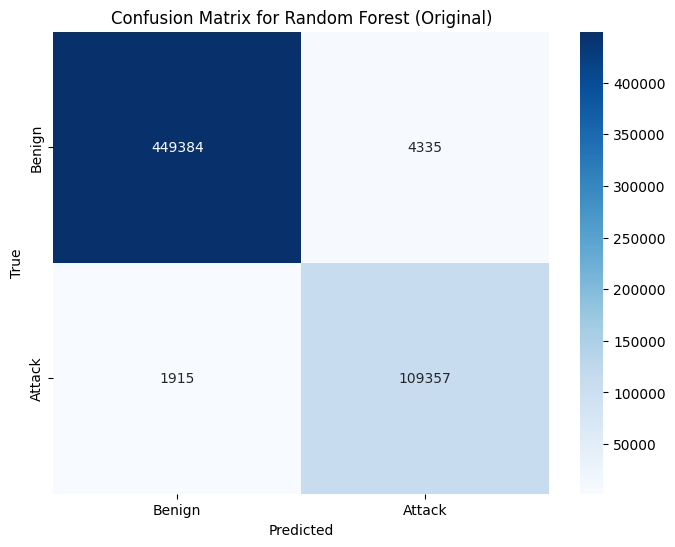

Metrics by Label (Original):
                         Label  Accuracy    Method
0                       BENIGN  0.990446  Original
1                     DoS Hulk  0.978127  Original
2                         DDoS  0.998750  Original
3                     PortScan  1.000000  Original
4             DoS Slowhttptest  0.992727  Original
5                  FTP-Patator  0.984868  Original
6                DoS GoldenEye  0.990282  Original
7                          Bot  0.457801  Original
8                DoS slowloris  0.993960  Original
9                  SSH-Patator  0.525869  Original
10    Web Attack - Brute Force  0.880795  Original
11            Web Attack - XSS  0.961538  Original
12  Web Attack - Sql Injection  0.500000  Original
13                Infiltration  0.428571  Original
14                  Heartbleed  1.000000  Original


In [28]:
# Predict and evaluate on the test set
rf_metrics["original"] = test_metrics("Random Forest", rf_model, "Original", scaler)

#### With random oversampler

In [29]:
rf_model_random = RandomForestClassifier(verbose=1, n_jobs=-1)
rf_model_random.fit(scaler_random.transform(X_random_train), Y_random_train.is_attack)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   49.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.9min finished


RandomForestClassifier(n_jobs=-1, verbose=1)

Random Forest with Random Oversampling Test Set Performance


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.5s finished


Classification Report (Test Random Forest (Random Oversampling)):
              precision    recall  f1-score   support

           0     0.9970    0.9698    0.9832    453719
           1     0.8891    0.9880    0.9360    111272

    accuracy                         0.9734    564991
   macro avg     0.9430    0.9789    0.9596    564991
weighted avg     0.9757    0.9734    0.9739    564991

Accuracy: 0.973373027180964
Precision: 0.9757367414142306
Recall: 0.973373027180964
F1 Score: 0.9738904743080002
AUC: 0.9789039925346467


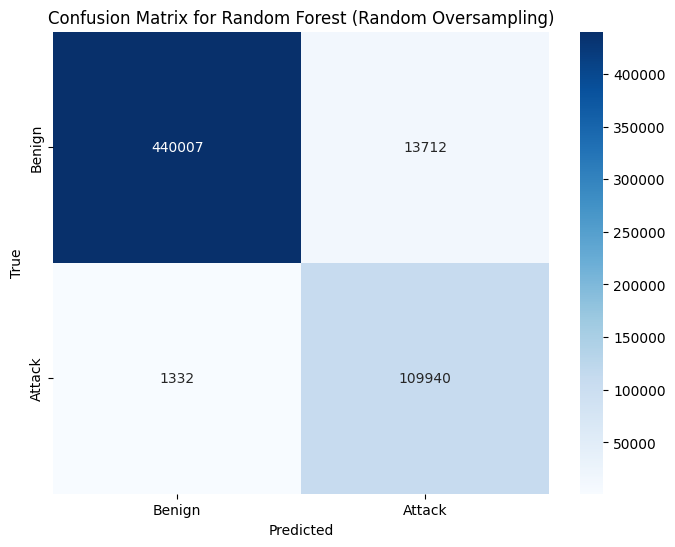

Metrics by Label (Random Oversampling):
                         Label  Accuracy               Method
0                       BENIGN  0.969779  Random Oversampling
1                     DoS Hulk  0.978388  Random Oversampling
2                         DDoS  0.998633  Random Oversampling
3                     PortScan  1.000000  Random Oversampling
4             DoS Slowhttptest  0.994545  Random Oversampling
5                  FTP-Patator  0.998108  Random Oversampling
6                DoS GoldenEye  0.991254  Random Oversampling
7                          Bot  0.749361  Random Oversampling
8                DoS slowloris  0.993960  Random Oversampling
9                  SSH-Patator  0.882952  Random Oversampling
10    Web Attack - Brute Force  0.920530  Random Oversampling
11            Web Attack - XSS  0.961538  Random Oversampling
12  Web Attack - Sql Injection  0.750000  Random Oversampling
13                Infiltration  0.571429  Random Oversampling
14                  Heartbleed

In [30]:
# Predict and evaluate on the test set
rf_metrics["random"] = test_metrics("Random Forest", rf_model_random, "Random Oversampling", scaler_random)

#### With SMOTE

In [31]:
rf_model_smote = RandomForestClassifier(verbose=1, n_jobs=-1)
rf_model_smote.fit(scaler_smote.transform(X_smote_train), Y_smote_train.is_attack)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   55.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.1min finished


RandomForestClassifier(n_jobs=-1, verbose=1)

Random Forest with SMOTE Test Set Performance


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.5s finished


Classification Report (Test Random Forest (SMOTE)):
              precision    recall  f1-score   support

           0     0.9973    0.9680    0.9824    453719
           1     0.8836    0.9893    0.9335    111272

    accuracy                         0.9722    564991
   macro avg     0.9405    0.9787    0.9580    564991
weighted avg     0.9749    0.9722    0.9728    564991

Accuracy: 0.9722243363168617
Precision: 0.9749000676591014
Recall: 0.9722243363168617
F1 Score: 0.9728009787266748
AUC: 0.9786500347644719


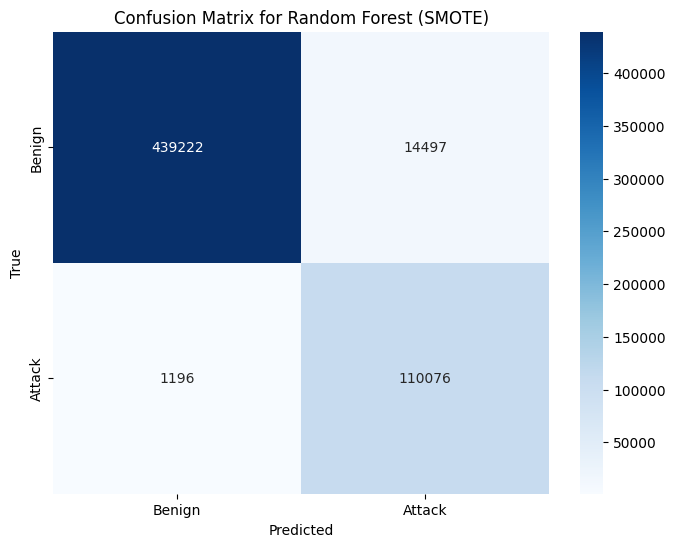

Metrics by Label (SMOTE):
                         Label  Accuracy Method
0                       BENIGN  0.968049  SMOTE
1                     DoS Hulk  0.980106  SMOTE
2                         DDoS  0.998594  SMOTE
3                     PortScan  1.000000  SMOTE
4             DoS Slowhttptest  0.995455  SMOTE
5                  FTP-Patator  0.999369  SMOTE
6                DoS GoldenEye  0.991740  SMOTE
7                          Bot  0.790281  SMOTE
8                DoS slowloris  0.995686  SMOTE
9                  SSH-Patator  0.905852  SMOTE
10    Web Attack - Brute Force  0.943709  SMOTE
11            Web Attack - XSS  0.976923  SMOTE
12  Web Attack - Sql Injection  0.750000  SMOTE
13                Infiltration  0.571429  SMOTE
14                  Heartbleed  1.000000  SMOTE


In [32]:
# Predict and evaluate on the test set
rf_metrics["smote"] = test_metrics("Random Forest", rf_model_smote, "SMOTE", scaler_smote)

#### With ADASYN

In [33]:
rf_model_adasyn = RandomForestClassifier(verbose=1, n_jobs=-1)
rf_model_adasyn.fit(scaler_adasyn.transform(X_adasyn_train), Y_adasyn_train.is_attack)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   49.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.8min finished


RandomForestClassifier(n_jobs=-1, verbose=1)

Random Forest with ADASYN Test Set Performance


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.5s finished


Classification Report (Test Random Forest (ADASYN)):
              precision    recall  f1-score   support

           0     0.9971    0.9716    0.9842    453719
           1     0.8951    0.9884    0.9394    111272

    accuracy                         0.9749    564991
   macro avg     0.9461    0.9800    0.9618    564991
weighted avg     0.9770    0.9749    0.9753    564991

Accuracy: 0.9748880955625842
Precision: 0.9769830669123931
Recall: 0.9748880955625842
F1 Score: 0.9753476339890228
AUC: 0.9799795757708064


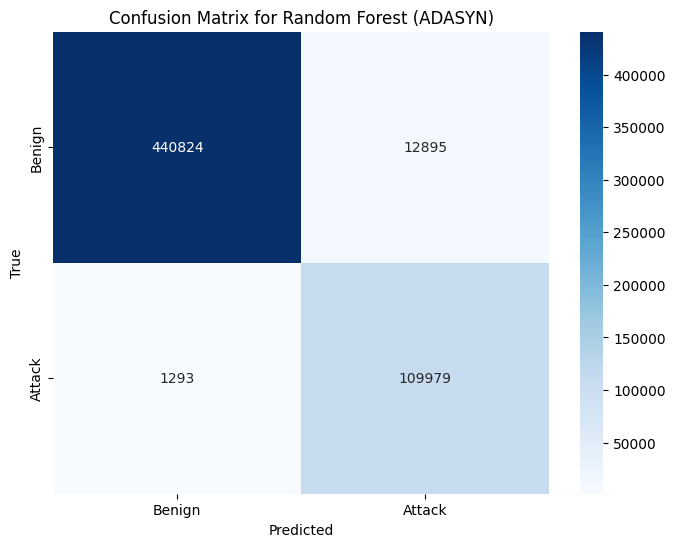

Metrics by Label (ADASYN):
                         Label  Accuracy  Method
0                       BENIGN  0.971579  ADASYN
1                     DoS Hulk  0.980693  ADASYN
2                         DDoS  0.998711  ADASYN
3                     PortScan  1.000000  ADASYN
4             DoS Slowhttptest  0.997273  ADASYN
5                  FTP-Patator  0.987390  ADASYN
6                DoS GoldenEye  0.992711  ADASYN
7                          Bot  0.639386  ADASYN
8                DoS slowloris  0.995686  ADASYN
9                  SSH-Patator  0.862595  ADASYN
10    Web Attack - Brute Force  0.930464  ADASYN
11            Web Attack - XSS  0.992308  ADASYN
12  Web Attack - Sql Injection  0.750000  ADASYN
13                Infiltration  0.571429  ADASYN
14                  Heartbleed  1.000000  ADASYN


In [34]:
# Predict and evaluate on the test set
rf_metrics["adasyn"] = test_metrics("Random Forest", rf_model_adasyn, "ADASYN", scaler_adasyn)

In [35]:
# Combine metrics into one DataFrame
combined_metrics_rf = pd.concat([rf_metrics["adasyn"][1], rf_metrics["original"][1], rf_metrics["random"][1], rf_metrics["smote"][1]])
# Pivot the table to get accuracy for each method as columns in the specified order
accuracy_pivot_rf = combined_metrics_rf.pivot(index='Label', columns='Method', values='Accuracy')
accuracy_pivot_rf = accuracy_pivot_rf[['Original', 'Random Oversampling', 'SMOTE', 'ADASYN']]
print("Accuracy by Label and Method:")
print(accuracy_pivot_rf)

Accuracy by Label and Method:
Method                      Original  Random Oversampling     SMOTE    ADASYN
Label                                                                        
BENIGN                      0.990446             0.969779  0.968049  0.971579
Bot                         0.457801             0.749361  0.790281  0.639386
DDoS                        0.998750             0.998633  0.998594  0.998711
DoS GoldenEye               0.990282             0.991254  0.991740  0.992711
DoS Hulk                    0.978127             0.978388  0.980106  0.980693
DoS Slowhttptest            0.992727             0.994545  0.995455  0.997273
DoS slowloris               0.993960             0.993960  0.995686  0.995686
FTP-Patator                 0.984868             0.998108  0.999369  0.987390
Heartbleed                  1.000000             1.000000  1.000000  1.000000
Infiltration                0.428571             0.571429  0.571429  0.571429
PortScan                    1.0000

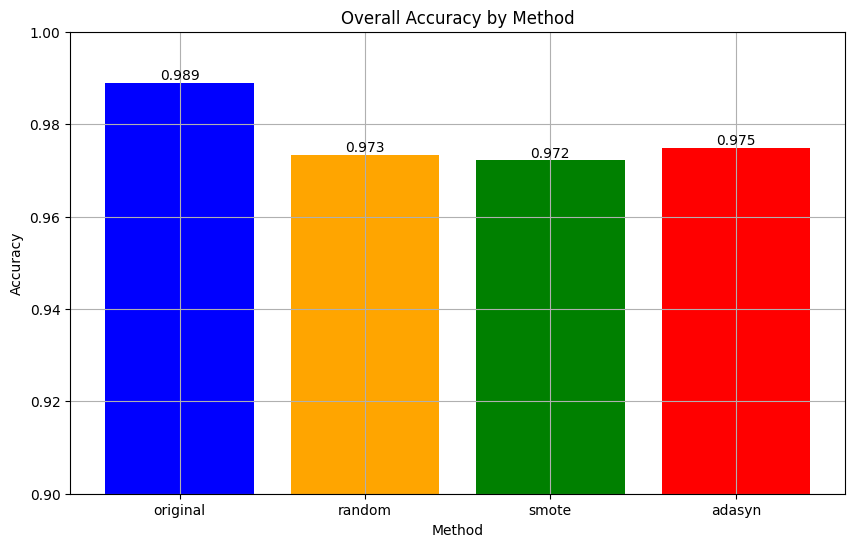

In [36]:
plot_overall_accuracy(rf_metrics)

### Gradient Boost (XGB)

In [37]:
xgb_metrics = {}

In [38]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(n_jobs=-1)
xgb_model.fit(scaler.transform(X_train), Y_train.is_attack)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, random_state=None, ...)

XGBoost with Original Test Set Performance
Classification Report (Test XGBoost (Original)):
              precision    recall  f1-score   support

           0     0.9958    0.9903    0.9930    453719
           1     0.9614    0.9828    0.9720    111272

    accuracy                         0.9888    564991
   macro avg     0.9786    0.9866    0.9825    564991
weighted avg     0.9890    0.9888    0.9889    564991

Accuracy: 0.9888476099619286
Precision: 0.9889983621979145
Recall: 0.9888476099619286
F1 Score: 0.9888937658065841
AUC: 0.9865751379906303


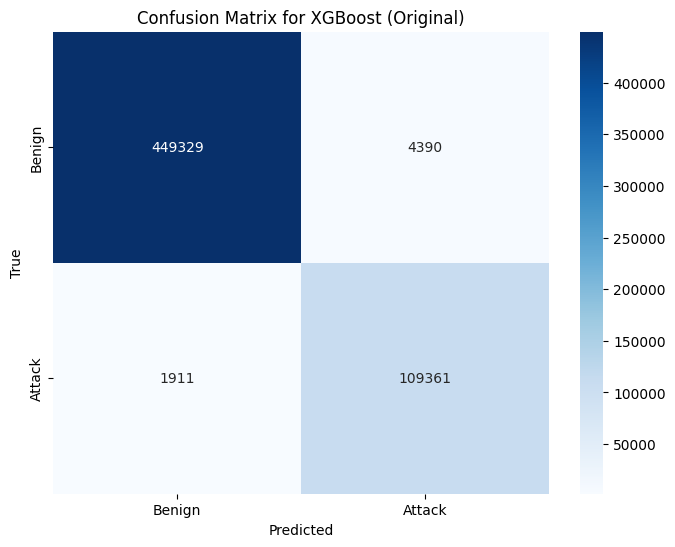

Metrics by Label (Original):
                         Label  Accuracy    Method
0                       BENIGN  0.990324  Original
1                     DoS Hulk  0.978388  Original
2                         DDoS  0.998633  Original
3                     PortScan  1.000000  Original
4             DoS Slowhttptest  0.996364  Original
5                  FTP-Patator  0.985498  Original
6                DoS GoldenEye  0.997570  Original
7                          Bot  0.398977  Original
8                DoS slowloris  0.993097  Original
9                  SSH-Patator  0.525869  Original
10    Web Attack - Brute Force  0.880795  Original
11            Web Attack - XSS  0.961538  Original
12  Web Attack - Sql Injection  0.500000  Original
13                Infiltration  0.285714  Original
14                  Heartbleed  1.000000  Original


In [39]:
# Predict and evaluate on the test set
# Original Dataset
xgb_metrics["original"] = test_metrics("XGBoost", xgb_model, "Original", scaler)

In [40]:
xgb_model_random = xgb.XGBClassifier(n_jobs=-1)
xgb_model_random.fit(scaler_random.transform(X_random_train), Y_random_train.is_attack)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, random_state=None, ...)

XGBoost with Random Oversampling Test Set Performance
Classification Report (Test XGBoost (Random Oversampling)):
              precision    recall  f1-score   support

           0     0.9972    0.9695    0.9831    453719
           1     0.8882    0.9890    0.9359    111272

    accuracy                         0.9733    564991
   macro avg     0.9427    0.9792    0.9595    564991
weighted avg     0.9757    0.9733    0.9738    564991

Accuracy: 0.9733039995327359
Precision: 0.9757403825518012
Recall: 0.9733039995327359
F1 Score: 0.9738322560350485
AUC: 0.9792103378369093


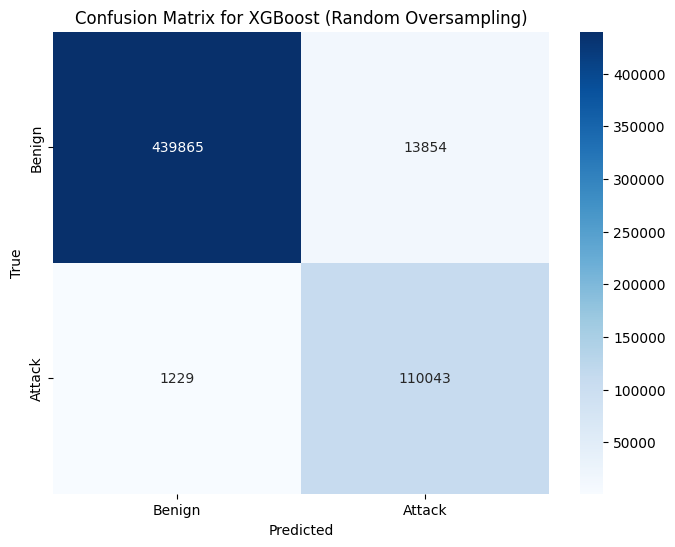

Metrics by Label (Random Oversampling):
                         Label  Accuracy               Method
0                       BENIGN  0.969466  Random Oversampling
1                     DoS Hulk  0.979301  Random Oversampling
2                         DDoS  0.998477  Random Oversampling
3                     PortScan  0.999969  Random Oversampling
4             DoS Slowhttptest  0.998182  Random Oversampling
5                  FTP-Patator  0.998108  Random Oversampling
6                DoS GoldenEye  0.998056  Random Oversampling
7                          Bot  0.846547  Random Oversampling
8                DoS slowloris  0.995686  Random Oversampling
9                  SSH-Patator  0.883800  Random Oversampling
10    Web Attack - Brute Force  0.940397  Random Oversampling
11            Web Attack - XSS  0.969231  Random Oversampling
12  Web Attack - Sql Injection  0.750000  Random Oversampling
13                Infiltration  0.571429  Random Oversampling
14                  Heartbleed

In [41]:
# Predict and evaluate on the test set
# Random Oversampling
xgb_metrics["random"] = test_metrics("XGBoost", xgb_model_random, "Random Oversampling", scaler_random)

In [42]:
xgb_model_smote = xgb.XGBClassifier(n_jobs=-1)
xgb_model_smote.fit(scaler_smote.transform(X_smote_train), Y_smote_train.is_attack)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, random_state=None, ...)

XGBoost with SMOTE Test Set Performance
Classification Report (Test XGBoost (SMOTE)):
              precision    recall  f1-score   support

           0     0.9974    0.9675    0.9822    453719
           1     0.8820    0.9896    0.9327    111272

    accuracy                         0.9719    564991
   macro avg     0.9397    0.9786    0.9575    564991
weighted avg     0.9747    0.9719    0.9725    564991

Accuracy: 0.9718791980757215
Precision: 0.9746514630752818
Recall: 0.9718791980757215
F1 Score: 0.9724740677916712
AUC: 0.9785708036405139


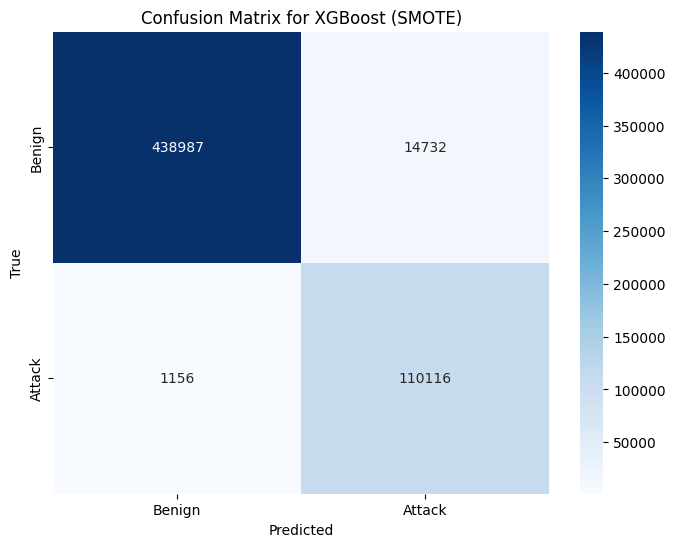

Metrics by Label (SMOTE):
                         Label  Accuracy Method
0                       BENIGN  0.967531  SMOTE
1                     DoS Hulk  0.980258  SMOTE
2                         DDoS  0.998516  SMOTE
3                     PortScan  1.000000  SMOTE
4             DoS Slowhttptest  0.996364  SMOTE
5                  FTP-Patator  0.998108  SMOTE
6                DoS GoldenEye  0.998056  SMOTE
7                          Bot  0.820972  SMOTE
8                DoS slowloris  0.995686  SMOTE
9                  SSH-Patator  0.911790  SMOTE
10    Web Attack - Brute Force  0.953642  SMOTE
11            Web Attack - XSS  0.984615  SMOTE
12  Web Attack - Sql Injection  0.750000  SMOTE
13                Infiltration  0.571429  SMOTE
14                  Heartbleed  1.000000  SMOTE


In [43]:
# Predict and evaluate on the test set
# SMOTE
xgb_metrics["smote"] = test_metrics("XGBoost", xgb_model_smote, "SMOTE", scaler_smote)

In [44]:
xgb_model_adasyn = xgb.XGBClassifier(n_jobs=-1)
xgb_model_adasyn.fit(scaler_adasyn.transform(X_adasyn_train), Y_adasyn_train.is_attack)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, random_state=None, ...)

XGBoost with ADASYN Test Set Performance
Classification Report (Test XGBoost (ADASYN)):
              precision    recall  f1-score   support

           0     0.9970    0.9736    0.9852    453719
           1     0.9019    0.9881    0.9430    111272

    accuracy                         0.9765    564991
   macro avg     0.9495    0.9809    0.9641    564991
weighted avg     0.9783    0.9765    0.9769    564991

Accuracy: 0.9764845811703196
Precision: 0.978273799545184
Recall: 0.9764845811703196
F1 Score: 0.9768812289418751
AUC: 0.9808548809333403


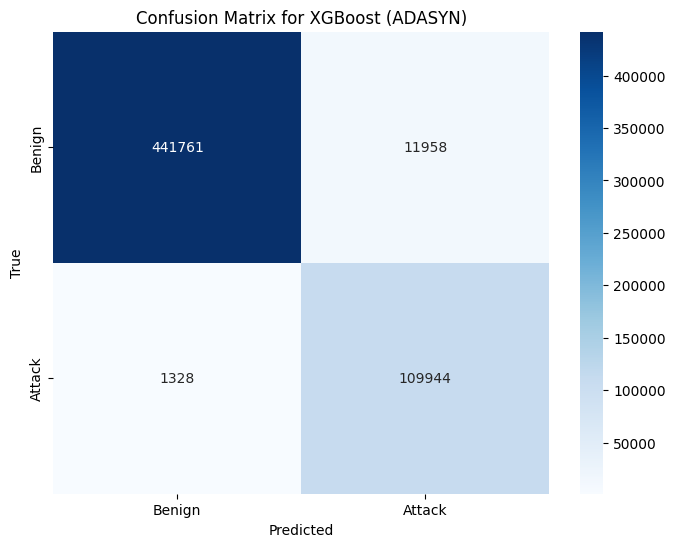

Metrics by Label (ADASYN):
                         Label  Accuracy  Method
0                       BENIGN  0.973644  ADASYN
1                     DoS Hulk  0.980106  ADASYN
2                         DDoS  0.998555  ADASYN
3                     PortScan  1.000000  ADASYN
4             DoS Slowhttptest  0.997273  ADASYN
5                  FTP-Patator  0.987390  ADASYN
6                DoS GoldenEye  0.999514  ADASYN
7                          Bot  0.685422  ADASYN
8                DoS slowloris  0.996549  ADASYN
9                  SSH-Patator  0.832061  ADASYN
10    Web Attack - Brute Force  0.927152  ADASYN
11            Web Attack - XSS  0.992308  ADASYN
12  Web Attack - Sql Injection  0.750000  ADASYN
13                Infiltration  0.571429  ADASYN
14                  Heartbleed  1.000000  ADASYN


In [45]:
# Predict and evaluate on the test set
# ADASYN
xgb_metrics["adasyn"] = test_metrics("XGBoost", xgb_model_adasyn, "ADASYN", scaler_adasyn)

In [46]:
# Combine metrics into one DataFrame
combined_metrics_xgb = pd.concat([xgb_metrics["adasyn"][1], xgb_metrics["original"][1], xgb_metrics["random"][1], xgb_metrics["smote"][1]])
# Pivot the table to get accuracy for each method as columns in the specified order
accuracy_pivot_xgb = combined_metrics_xgb.pivot(index='Label', columns='Method', values='Accuracy')
accuracy_pivot_xgb = accuracy_pivot_xgb[['Original', 'Random Oversampling', 'SMOTE', 'ADASYN']]
print("Accuracy by Label and Method:")
print(accuracy_pivot_xgb)

Accuracy by Label and Method:
Method                      Original  Random Oversampling     SMOTE    ADASYN
Label                                                                        
BENIGN                      0.990324             0.969466  0.967531  0.973644
Bot                         0.398977             0.846547  0.820972  0.685422
DDoS                        0.998633             0.998477  0.998516  0.998555
DoS GoldenEye               0.997570             0.998056  0.998056  0.999514
DoS Hulk                    0.978388             0.979301  0.980258  0.980106
DoS Slowhttptest            0.996364             0.998182  0.996364  0.997273
DoS slowloris               0.993097             0.995686  0.995686  0.996549
FTP-Patator                 0.985498             0.998108  0.998108  0.987390
Heartbleed                  1.000000             1.000000  1.000000  1.000000
Infiltration                0.285714             0.571429  0.571429  0.571429
PortScan                    1.0000

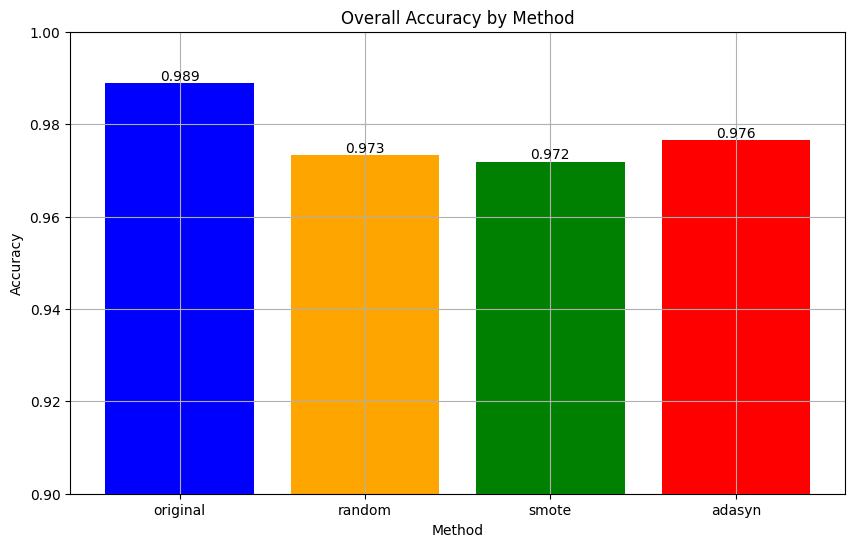

In [47]:
plot_overall_accuracy(xgb_metrics)

### AdaBoost

In [48]:
ada_metrics = {}

In [49]:
from sklearn.ensemble import AdaBoostClassifier

ada_model = AdaBoostClassifier(algorithm='SAMME')
ada_model.fit(scaler.transform(X_train), Y_train.is_attack)

AdaBoostClassifier(algorithm='SAMME')

AdaBoost with Original Test Set Performance
Classification Report (Test AdaBoost (Original)):
              precision    recall  f1-score   support

           0     0.9595    0.9920    0.9755    453719
           1     0.9621    0.8295    0.8909    111272

    accuracy                         0.9600    564991
   macro avg     0.9608    0.9107    0.9332    564991
weighted avg     0.9601    0.9600    0.9588    564991

Accuracy: 0.9599852033041234
Precision: 0.9600556344851168
Recall: 0.9599852033041234
F1 Score: 0.9588362569510817
AUC: 0.9107289915288951


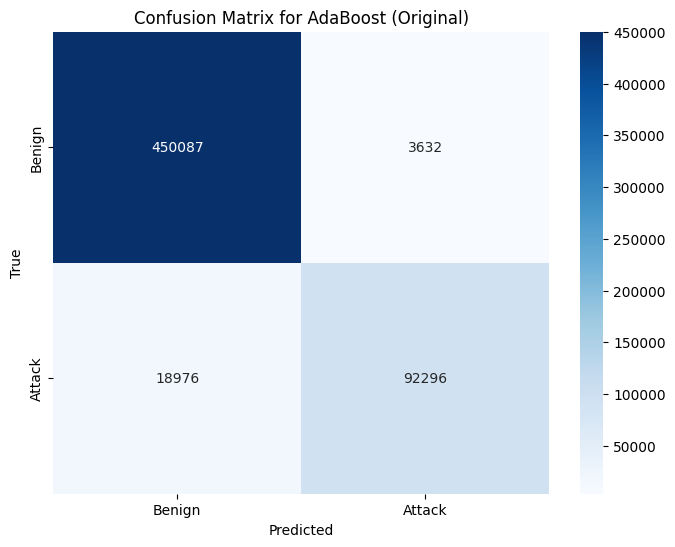

Metrics by Label (Original):
                         Label  Accuracy    Method
0                       BENIGN  0.991995  Original
1                     DoS Hulk  0.709956  Original
2                         DDoS  0.967501  Original
3                     PortScan  0.993892  Original
4             DoS Slowhttptest  0.565455  Original
5                  FTP-Patator  0.425599  Original
6                DoS GoldenEye  0.488338  Original
7                          Bot  0.258312  Original
8                DoS slowloris  0.477135  Original
9                  SSH-Patator  0.000848  Original
10    Web Attack - Brute Force  0.758278  Original
11            Web Attack - XSS  0.923077  Original
12  Web Attack - Sql Injection  0.000000  Original
13                Infiltration  0.000000  Original
14                  Heartbleed  1.000000  Original


In [50]:
# Predict and evaluate on the test set
ada_metrics["original"] = test_metrics("AdaBoost", ada_model, "Original", scaler)

In [51]:
ada_model_random = AdaBoostClassifier(algorithm='SAMME')
ada_model_random.fit(scaler_random.transform(X_random_train), Y_random_train.is_attack)

AdaBoostClassifier(algorithm='SAMME')

AdaBoost with Random Oversampling Test Set Performance
Classification Report (Test AdaBoost (Random Oversampling)):
              precision    recall  f1-score   support

           0     0.9741    0.8592    0.9131    453719
           1     0.6124    0.9069    0.7311    111272

    accuracy                         0.8686    564991
   macro avg     0.7932    0.8831    0.8221    564991
weighted avg     0.9029    0.8686    0.8772    564991

Accuracy: 0.8686120663868983
Precision: 0.9028730076569125
Recall: 0.8686120663868983
F1 Score: 0.8772298371729309
AUC: 0.8830591281823519


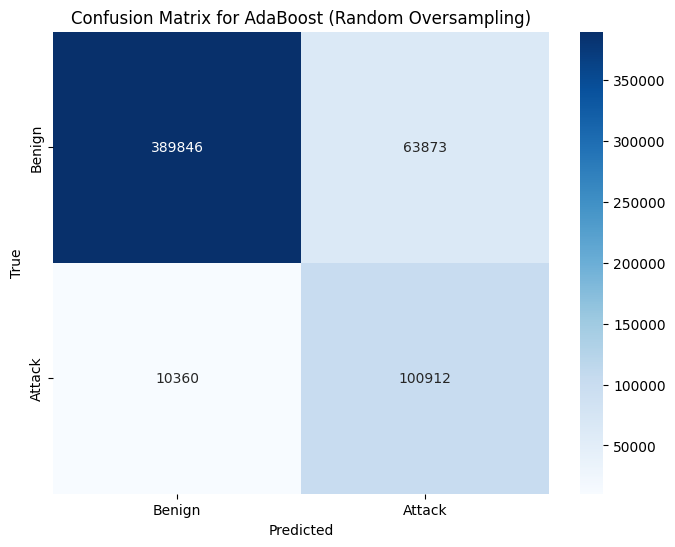

Metrics by Label (Random Oversampling):
                         Label  Accuracy               Method
0                       BENIGN  0.859223  Random Oversampling
1                     DoS Hulk  0.800818  Random Oversampling
2                         DDoS  0.977267  Random Oversampling
3                     PortScan  0.996033  Random Oversampling
4             DoS Slowhttptest  0.880000  Random Oversampling
5                  FTP-Patator  0.996847  Random Oversampling
6                DoS GoldenEye  0.987366  Random Oversampling
7                          Bot  0.258312  Random Oversampling
8                DoS slowloris  0.972390  Random Oversampling
9                  SSH-Patator  0.997455  Random Oversampling
10    Web Attack - Brute Force  1.000000  Random Oversampling
11            Web Attack - XSS  1.000000  Random Oversampling
12  Web Attack - Sql Injection  1.000000  Random Oversampling
13                Infiltration  0.571429  Random Oversampling
14                  Heartbleed

In [52]:
# Predict and evaluate on the test set
ada_metrics["random"] = test_metrics("AdaBoost", ada_model_random, "Random Oversampling", scaler_random)

In [53]:
ada_model_smote = AdaBoostClassifier(algorithm='SAMME')
ada_model_smote.fit(scaler_smote.transform(X_smote_train), Y_smote_train.is_attack)

AdaBoostClassifier(algorithm='SAMME')

AdaBoost with SMOTE Test Set Performance
Classification Report (Test AdaBoost (SMOTE)):
              precision    recall  f1-score   support

           0     0.9917    0.8245    0.9004    453719
           1     0.5760    0.9720    0.7233    111272

    accuracy                         0.8535    564991
   macro avg     0.7838    0.8982    0.8119    564991
weighted avg     0.9099    0.8535    0.8655    564991

Accuracy: 0.8535498795556036
Precision: 0.9098504215667096
Recall: 0.8535498795556036
F1 Score: 0.8655411265765997
AUC: 0.8982422458405165


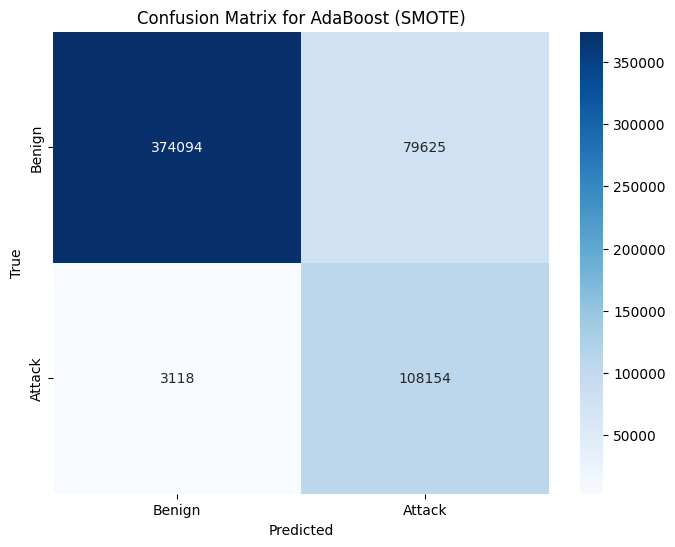

Metrics by Label (SMOTE):
                         Label  Accuracy Method
0                       BENIGN  0.824506  SMOTE
1                     DoS Hulk  0.955385  SMOTE
2                         DDoS  0.978946  SMOTE
3                     PortScan  0.997166  SMOTE
4             DoS Slowhttptest  0.934545  SMOTE
5                  FTP-Patator  0.996847  SMOTE
6                DoS GoldenEye  0.987852  SMOTE
7                          Bot  0.258312  SMOTE
8                DoS slowloris  0.964625  SMOTE
9                  SSH-Patator  0.998304  SMOTE
10    Web Attack - Brute Force  1.000000  SMOTE
11            Web Attack - XSS  1.000000  SMOTE
12  Web Attack - Sql Injection  1.000000  SMOTE
13                Infiltration  0.714286  SMOTE
14                  Heartbleed  1.000000  SMOTE


In [54]:
# Predict and evaluate on the test set
ada_metrics["smote"] = test_metrics("AdaBoost", ada_model_smote, "SMOTE", scaler_smote)

In [55]:
ada_model_adasyn = AdaBoostClassifier(algorithm='SAMME')
ada_model_adasyn.fit(scaler_adasyn.transform(X_adasyn_train), Y_adasyn_train.is_attack)

AdaBoostClassifier(algorithm='SAMME')

AdaBoost with ADASYN Test Set Performance
Classification Report (Test AdaBoost (ADASYN)):
              precision    recall  f1-score   support

           0     0.9510    0.8425    0.8935    453719
           1     0.5617    0.8229    0.6676    111272

    accuracy                         0.8387    564991
   macro avg     0.7563    0.8327    0.7806    564991
weighted avg     0.8743    0.8387    0.8490    564991

Accuracy: 0.8386576069353318
Precision: 0.874301841330705
Recall: 0.8386576069353318
F1 Score: 0.8489966488171201
AUC: 0.832694997457311


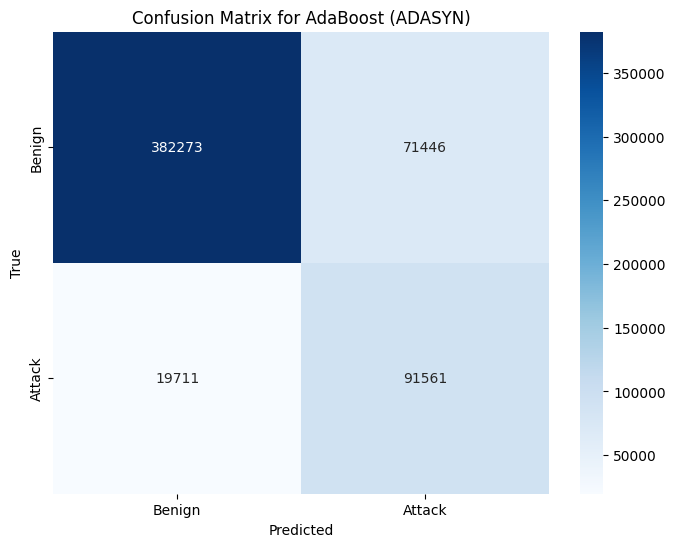

Metrics by Label (ADASYN):
                         Label  Accuracy  Method
0                       BENIGN  0.842532  ADASYN
1                     DoS Hulk  0.770552  ADASYN
2                         DDoS  0.668919  ADASYN
3                     PortScan  0.991656  ADASYN
4             DoS Slowhttptest  0.937273  ADASYN
5                  FTP-Patator  1.000000  ADASYN
6                DoS GoldenEye  0.977162  ADASYN
7                          Bot  0.286445  ADASYN
8                DoS slowloris  0.986195  ADASYN
9                  SSH-Patator  0.998304  ADASYN
10    Web Attack - Brute Force  1.000000  ADASYN
11            Web Attack - XSS  0.992308  ADASYN
12  Web Attack - Sql Injection  1.000000  ADASYN
13                Infiltration  0.571429  ADASYN
14                  Heartbleed  1.000000  ADASYN


In [56]:
# Predict and evaluate on the test set
ada_metrics["adasyn"] = test_metrics("AdaBoost", ada_model_adasyn, "ADASYN", scaler_adasyn)

In [57]:
# Combine metrics into one DataFrame
combined_metrics_ada = pd.concat([ada_metrics["adasyn"][1], ada_metrics["original"][1], ada_metrics["random"][1], ada_metrics["smote"][1]])

# Pivot the table to get accuracy for each method as columns in the specified order
accuracy_pivot_ada = combined_metrics_ada.pivot(index='Label', columns='Method', values='Accuracy')
accuracy_pivot_ada = accuracy_pivot_ada[['Original', 'Random Oversampling', 'SMOTE', 'ADASYN']]
print("Accuracy by Label and Method (AdaBoost):")
print(accuracy_pivot_ada)

Accuracy by Label and Method (AdaBoost):
Method                      Original  Random Oversampling     SMOTE    ADASYN
Label                                                                        
BENIGN                      0.991995             0.859223  0.824506  0.842532
Bot                         0.258312             0.258312  0.258312  0.286445
DDoS                        0.967501             0.977267  0.978946  0.668919
DoS GoldenEye               0.488338             0.987366  0.987852  0.977162
DoS Hulk                    0.709956             0.800818  0.955385  0.770552
DoS Slowhttptest            0.565455             0.880000  0.934545  0.937273
DoS slowloris               0.477135             0.972390  0.964625  0.986195
FTP-Patator                 0.425599             0.996847  0.996847  1.000000
Heartbleed                  1.000000             1.000000  1.000000  1.000000
Infiltration                0.000000             0.571429  0.714286  0.571429
PortScan               

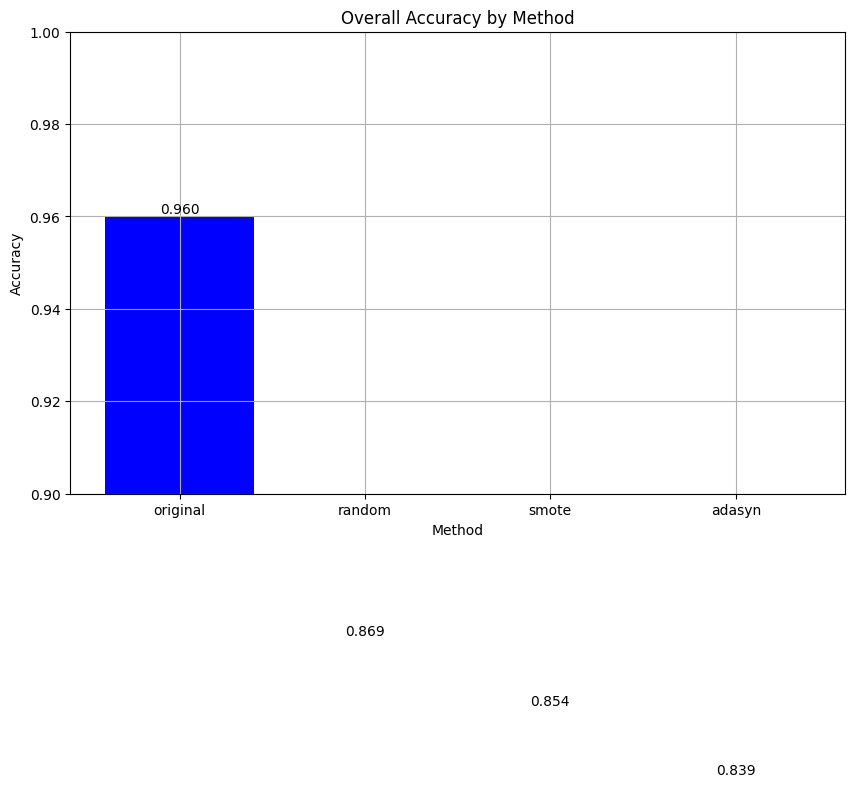

In [58]:
plot_overall_accuracy(ada_metrics)

### Decision Tree

In [59]:
dt_metrics = {}

In [60]:
decision_tree_model = DecisionTreeClassifier()
decision_tree_model.fit(scaler.transform(X_train), Y_train.is_attack)

DecisionTreeClassifier()

Decision Tree with Original Test Set Performance
Classification Report (Test Decision Tree (Original)):
              precision    recall  f1-score   support

           0     0.9956    0.9903    0.9929    453719
           1     0.9611    0.9822    0.9715    111272

    accuracy                         0.9887    564991
   macro avg     0.9784    0.9862    0.9822    564991
weighted avg     0.9888    0.9887    0.9887    564991

Accuracy: 0.9886582264142261
Precision: 0.9888069252328201
Recall: 0.9886582264142261
F1 Score: 0.9887043643089077
AUC: 0.9862028618667981


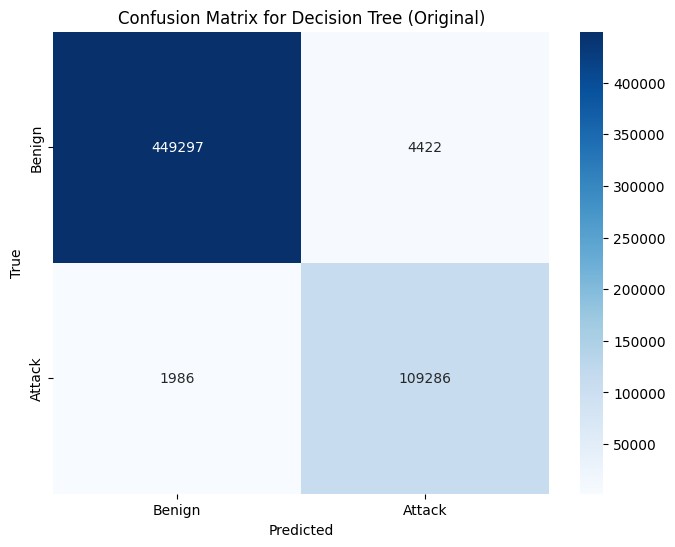

Metrics by Label (Original):
                         Label  Accuracy    Method
0                       BENIGN  0.990254  Original
1                     DoS Hulk  0.977584  Original
2                         DDoS  0.998555  Original
3                     PortScan  0.999969  Original
4             DoS Slowhttptest  0.957273  Original
5                  FTP-Patator  0.984868  Original
6                DoS GoldenEye  0.985909  Original
7                          Bot  0.480818  Original
8                DoS slowloris  0.994823  Original
9                  SSH-Patator  0.525021  Original
10    Web Attack - Brute Force  0.877483  Original
11            Web Attack - XSS  0.969231  Original
12  Web Attack - Sql Injection  0.250000  Original
13                Infiltration  0.428571  Original
14                  Heartbleed  1.000000  Original


In [61]:
# Predict and evaluate on the test set
dt_metrics["original"] = test_metrics("Decision Tree", decision_tree_model, "Original", scaler)

In [62]:
decision_tree_model_random = DecisionTreeClassifier()
decision_tree_model_random.fit(scaler_random.transform(X_random_train), Y_random_train.is_attack)

DecisionTreeClassifier()

Decision Tree with Random Oversampling Test Set Performance
Classification Report (Test Decision Tree (Random Oversampling)):
              precision    recall  f1-score   support

           0     0.9966    0.9708    0.9835    453719
           1     0.8923    0.9867    0.9371    111272

    accuracy                         0.9739    564991
   macro avg     0.9445    0.9787    0.9603    564991
weighted avg     0.9761    0.9739    0.9744    564991

Accuracy: 0.9739181686079955
Precision: 0.9760932225044914
Recall: 0.9739181686079955
F1 Score: 0.974402017866161
AUC: 0.978738077688858


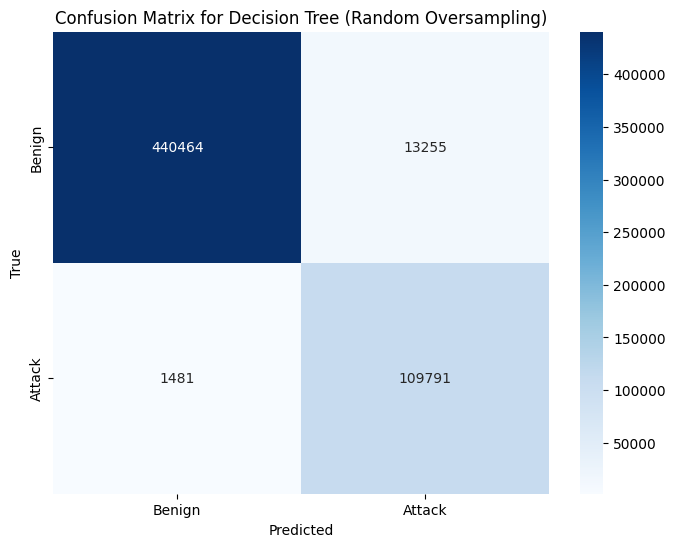

Metrics by Label (Random Oversampling):
                         Label  Accuracy               Method
0                       BENIGN  0.970786  Random Oversampling
1                     DoS Hulk  0.977649  Random Oversampling
2                         DDoS  0.998086  Random Oversampling
3                     PortScan  0.999969  Random Oversampling
4             DoS Slowhttptest  0.963636  Random Oversampling
5                  FTP-Patator  0.998108  Random Oversampling
6                DoS GoldenEye  0.983965  Random Oversampling
7                          Bot  0.672634  Random Oversampling
8                DoS slowloris  0.991372  Random Oversampling
9                  SSH-Patator  0.865988  Random Oversampling
10    Web Attack - Brute Force  0.927152  Random Oversampling
11            Web Attack - XSS  0.961538  Random Oversampling
12  Web Attack - Sql Injection  0.750000  Random Oversampling
13                Infiltration  0.571429  Random Oversampling
14                  Heartbleed

In [63]:
# Predict and evaluate on the test set
dt_metrics["random"] = test_metrics("Decision Tree", decision_tree_model_random, "Random Oversampling", scaler_random)

In [64]:
decision_tree_model_smote = DecisionTreeClassifier()
decision_tree_model_smote.fit(scaler_smote.transform(X_smote_train), Y_smote_train.is_attack)

DecisionTreeClassifier()

Decision Tree with SMOTE Test Set Performance
Classification Report (Test Decision Tree (SMOTE)):
              precision    recall  f1-score   support

           0     0.9967    0.9742    0.9853    453719
           1     0.9036    0.9869    0.9434    111272

    accuracy                         0.9767    564991
   macro avg     0.9501    0.9805    0.9644    564991
weighted avg     0.9784    0.9767    0.9771    564991

Accuracy: 0.9766775045974183
Precision: 0.97836902901942
Recall: 0.9766775045974183
F1 Score: 0.977058110565439
AUC: 0.9805341056640133


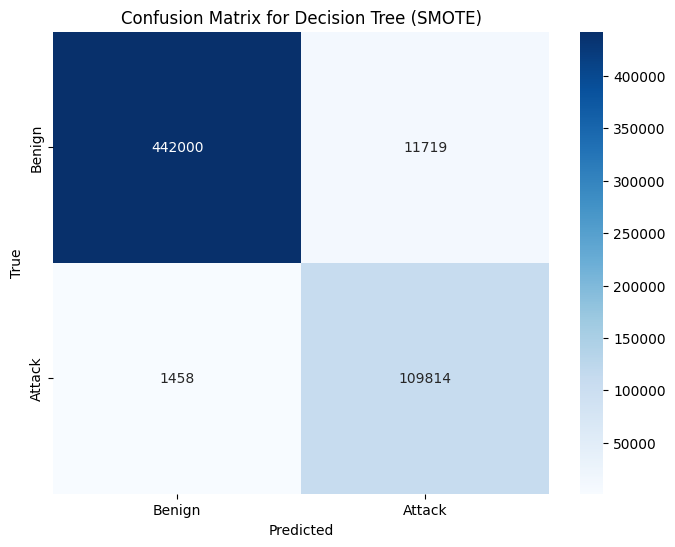

Metrics by Label (SMOTE):
                         Label  Accuracy Method
0                       BENIGN  0.974171  SMOTE
1                     DoS Hulk  0.977627  SMOTE
2                         DDoS  0.998516  SMOTE
3                     PortScan  0.999969  SMOTE
4             DoS Slowhttptest  0.986364  SMOTE
5                  FTP-Patator  0.997478  SMOTE
6                DoS GoldenEye  0.986395  SMOTE
7                          Bot  0.705882  SMOTE
8                DoS slowloris  0.993960  SMOTE
9                  SSH-Patator  0.838846  SMOTE
10    Web Attack - Brute Force  0.923841  SMOTE
11            Web Attack - XSS  0.961538  SMOTE
12  Web Attack - Sql Injection  0.750000  SMOTE
13                Infiltration  0.714286  SMOTE
14                  Heartbleed  1.000000  SMOTE


In [65]:
# Predict and evaluate on the test set
dt_metrics["smote"] = test_metrics("Decision Tree", decision_tree_model_smote, "SMOTE", scaler_smote)

In [66]:
decision_tree_model_adasyn = DecisionTreeClassifier()
decision_tree_model_adasyn.fit(scaler_adasyn.transform(X_adasyn_train), Y_adasyn_train.is_attack)

DecisionTreeClassifier()

Decision Tree with ADASYN Test Set Performance
Classification Report (Test Decision Tree (ADASYN)):
              precision    recall  f1-score   support

           0     0.9957    0.9877    0.9917    453719
           1     0.9515    0.9827    0.9669    111272

    accuracy                         0.9867    564991
   macro avg     0.9736    0.9852    0.9793    564991
weighted avg     0.9870    0.9867    0.9868    564991

Accuracy: 0.9867360719020303
Precision: 0.987021046399671
Recall: 0.9867360719020303
F1 Score: 0.9868161767425531
AUC: 0.9852129667639811


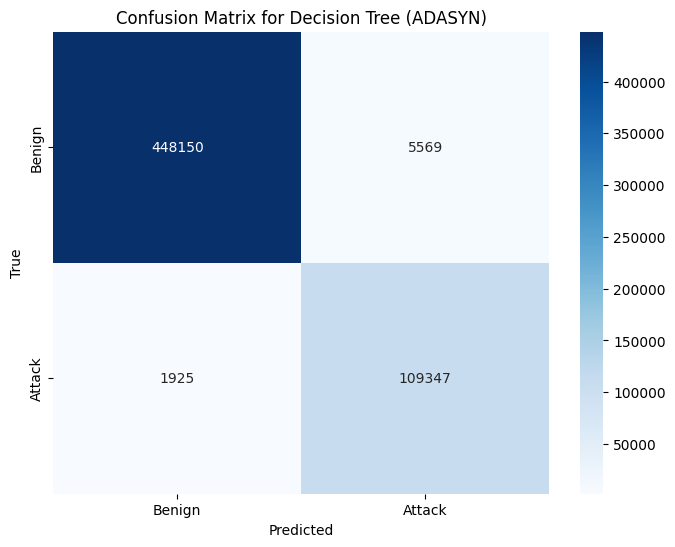

Metrics by Label (ADASYN):
                         Label  Accuracy  Method
0                       BENIGN  0.987726  ADASYN
1                     DoS Hulk  0.977453  ADASYN
2                         DDoS  0.998359  ADASYN
3                     PortScan  0.999906  ADASYN
4             DoS Slowhttptest  0.978182  ADASYN
5                  FTP-Patator  0.986129  ADASYN
6                DoS GoldenEye  0.984937  ADASYN
7                          Bot  0.526854  ADASYN
8                DoS slowloris  0.993097  ADASYN
9                  SSH-Patator  0.551315  ADASYN
10    Web Attack - Brute Force  0.890728  ADASYN
11            Web Attack - XSS  0.953846  ADASYN
12  Web Attack - Sql Injection  0.500000  ADASYN
13                Infiltration  0.571429  ADASYN
14                  Heartbleed  1.000000  ADASYN


In [67]:
# Predict and evaluate on the test set
dt_metrics["adasyn"] = test_metrics("Decision Tree", decision_tree_model_adasyn, "ADASYN", scaler_adasyn)

In [68]:
# Combine metrics into one DataFrame for Decision Tree
combined_metrics_dt = pd.concat([dt_metrics["adasyn"][1], dt_metrics["original"][1], dt_metrics["random"][1], dt_metrics["smote"][1]])
# Pivot the table to get accuracy for each method as columns in the specified order
accuracy_pivot_dt = combined_metrics_dt.pivot(index='Label', columns='Method', values='Accuracy')
accuracy_pivot_dt = accuracy_pivot_dt[['Original', 'Random Oversampling', 'SMOTE', 'ADASYN']]
print("Accuracy by Label and Method (Decision Tree):")
print(accuracy_pivot_dt)

Accuracy by Label and Method (Decision Tree):
Method                      Original  Random Oversampling     SMOTE    ADASYN
Label                                                                        
BENIGN                      0.990254             0.970786  0.974171  0.987726
Bot                         0.480818             0.672634  0.705882  0.526854
DDoS                        0.998555             0.998086  0.998516  0.998359
DoS GoldenEye               0.985909             0.983965  0.986395  0.984937
DoS Hulk                    0.977584             0.977649  0.977627  0.977453
DoS Slowhttptest            0.957273             0.963636  0.986364  0.978182
DoS slowloris               0.994823             0.991372  0.993960  0.993097
FTP-Patator                 0.984868             0.998108  0.997478  0.986129
Heartbleed                  1.000000             1.000000  1.000000  1.000000
Infiltration                0.428571             0.571429  0.714286  0.571429
PortScan          

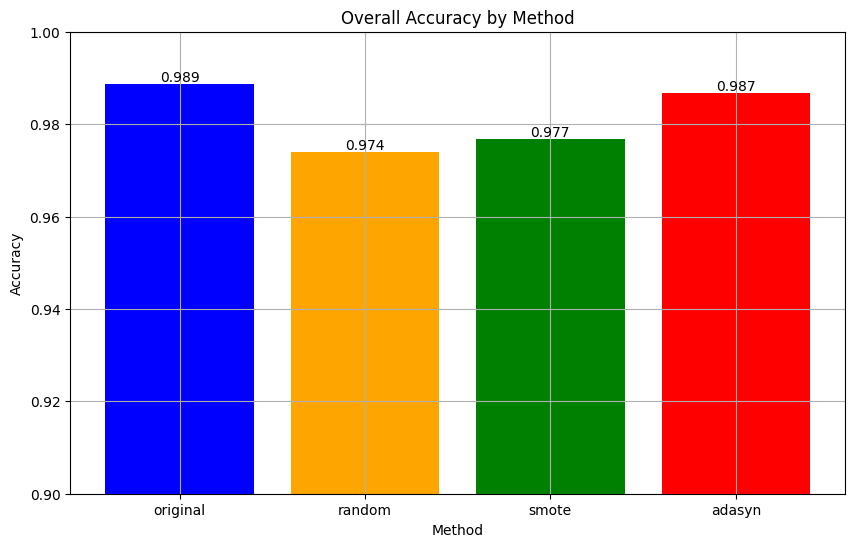

In [69]:
plot_overall_accuracy(dt_metrics)